In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

## Read in the Dataset

```
class 0 - "Acral Lentiginous Melanoma"
class 1 - "Beaus Line"
class 2 - "Blue Finger"
class 3 - "Clubbing"
class 4 - "Healthy Nail"
class 5 - "Koilonychia"
class 6 - "Muehrckes Lines"
class 7 - "Onychogryphosis"
class 8 - "Pitting"
class 9 - "Terry-s Nail"
```

In [6]:
image_shape = (128, 128, 3)

dataset = tf.keras.utils.image_dataset_from_directory(
    directory="dataset/v3",
    image_size=image_shape[:2],
)

x, y = [], []
for batch in dataset.take(-1):
    images, labels = batch
    x.append(images.numpy())
    y.append(labels.numpy())

x = np.concatenate(x)
y = np.concatenate(y)

x.shape, y.shape

Found 3050 files belonging to 10 classes.


((3050, 128, 128, 3), (3050,))

## Split into Train/Validation/Test at 70/15/15 Ratio

In [7]:
class_names = dataset.class_names
classes, count_by_class = np.unique(y, return_counts=True)
num_classes = len(classes)

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7, stratify=y)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, stratify=y_test)

In [8]:
print(
    f"total  : {count_by_class}\n"
    f"y_train: {np.unique(y_train, return_counts=True)[1]}\n"
    f"y_val  : {np.unique(y_val, return_counts=True)[1]}\n"
    f"y_test : {np.unique(y_test, return_counts=True)[1]}"
)

total  : [357 218 292 373 328 260 159 329 312 422]
y_train: [250 153 204 261 230 182 111 230 218 296]
y_val  : [53 33 44 56 49 39 24 49 47 63]
y_test : [54 32 44 56 49 39 24 50 47 63]


## Define Helpers

In [9]:
def plot_loss_and_accuracy(history) -> None:
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    ax1.set_title("Loss")
    ax1.plot(history.history["loss"], label="Train")
    ax1.plot(history.history["val_loss"], label="Validation")
    ax1.legend(loc="best")

    ax2.set_title("Accuracy")
    ax2.plot(history.history["accuracy"], label="Train")
    ax2.plot(history.history["val_accuracy"], label="Validation")
    ax2.legend(loc="best")

    plt.show()


def make_prediction(image):
    predictions = model.predict(np.expand_dims(image, axis=0), verbose=0)
    [pred] = predictions
    for index in pred.argsort()[::-1]:
        print(f"{pred[index] * 100:5.2f}% - {class_names[index]}")
    plt.imshow(image.astype("uint8"))

## Train and Evaluate

In [15]:
def get_model():
    return tf.keras.models.Sequential([
        tf.keras.layers.Rescaling(1 / 255, input_shape=image_shape),

        tf.keras.layers.Conv2D(32, 3, activation="relu"),
        tf.keras.layers.MaxPooling2D(2),
        tf.keras.layers.Conv2D(32, 3, activation="relu"),
        tf.keras.layers.MaxPooling2D(2),
        tf.keras.layers.Conv2D(64, 3, activation="relu"),
        tf.keras.layers.MaxPooling2D(2),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Dense(num_classes, activation="softmax"),
    ])

model = get_model()

In [16]:
optimizer = tf.keras.optimizers.Adam()

model.compile(optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [17]:
batch_size=64
epochs = 20

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                    validation_data=(x_val, y_val))

Epoch 1/20
34/34 [==============================] - 6s 117ms/step - loss: 2.2806 - accuracy: 0.1443 - val_loss: 2.1540 - val_accuracy: 0.2035
Epoch 2/20
34/34 [==============================] - 2s 49ms/step - loss: 2.0372 - accuracy: 0.2820 - val_loss: 1.8668 - val_accuracy: 0.3435
Epoch 3/20
34/34 [==============================] - 2s 47ms/step - loss: 1.8453 - accuracy: 0.3747 - val_loss: 1.7102 - val_accuracy: 0.3873
Epoch 4/20
34/34 [==============================] - 1s 43ms/step - loss: 1.6877 - accuracy: 0.4244 - val_loss: 1.5391 - val_accuracy: 0.4923
Epoch 5/20
34/34 [==============================] - 2s 48ms/step - loss: 1.5421 - accuracy: 0.4792 - val_loss: 1.5137 - val_accuracy: 0.4989
Epoch 6/20
34/34 [==============================] - 1s 43ms/step - loss: 1.4519 - accuracy: 0.5063 - val_loss: 1.4878 - val_accuracy: 0.4748
Epoch 7/20
34/34 [==============================] - 1s 42ms/step - loss: 1.3132 - accuracy: 0.5457 - val_loss: 1.5029 - val_accuracy: 0.5142
Epoch 8/20
3

loss=1.8260, accuracy=0.5502


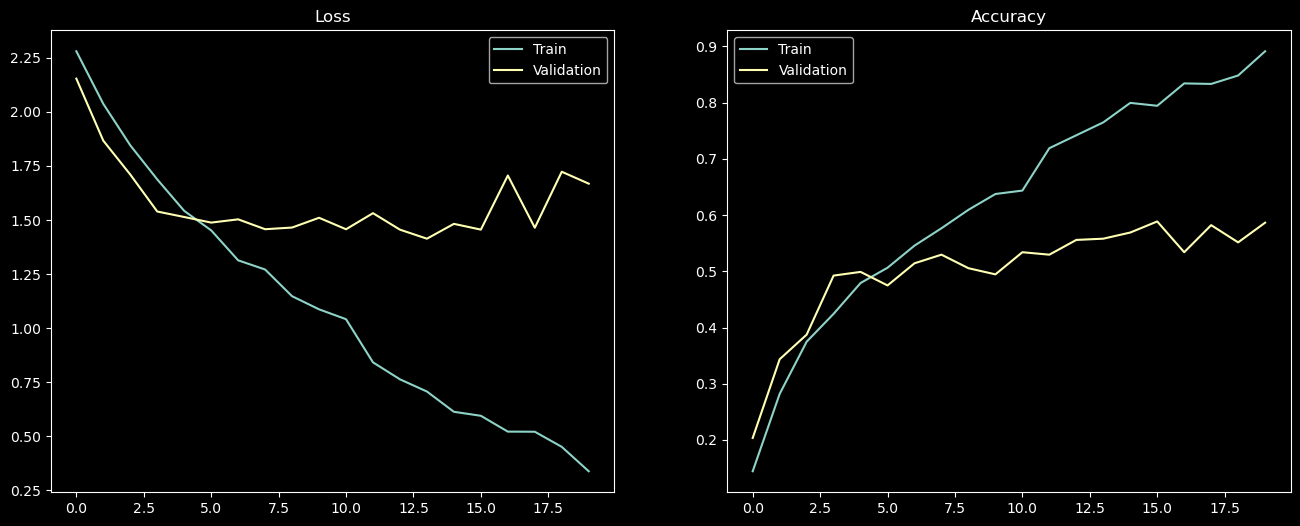

In [18]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)

print(f"{loss=:.4f}, {accuracy=:.4f}")
plot_loss_and_accuracy(history)

## Predict

93.25% - Terry-s Nail
 5.08% - Healthy Nail
 1.54% - Clubbing
 0.05% - Pitting
 0.05% - Beaus Line
 0.03% - Koilonychia
 0.01% - Onychogryphosis
 0.00% - Muehrckes Lines
 0.00% - Blue Finger
 0.00% - Acral Lentiginous Melanoma


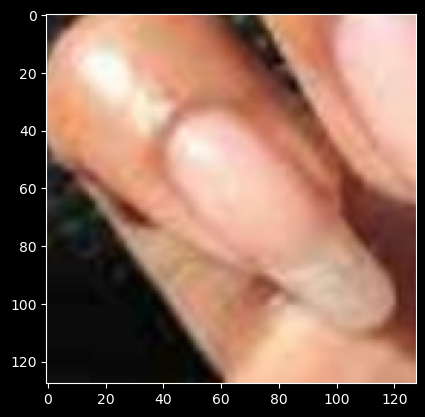

In [35]:
make_prediction(x_test[23])